In [1]:
from GG_mthesis import *
%matplotlib inline

In [2]:
sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set(font_scale=1.2)

In [3]:
#define the path
path = '.\\data\\02_intermediate\\tsg_orchestra\\b1903933_4_spatial_res.nc'

#open the dataset with the defined path
ds = xr.open_dataset(path) 

In [4]:
ds

<xarray.Dataset>
Dimensions:           (time: 2545)
Coordinates:
    lat               (time) float64 ...
    lon               (time) float64 ...
    depth             (time) float32 ...
  * time              (time) datetime64[ns] 2017-11-09T02:12:59.999680 ... 2017-11-10T23:37:59.997824
    distance_cum      (time) float64 ...
Data variables:
    attenuation       (time) float32 ...
    conductivity_tsg  (time) float32 ...
    chl-a             (time) float32 ...
    sal_tsg_cal       (time) float32 ...
    sal_tsg_nocal     (time) float32 ...
    temp_hull_1       (time) float32 ...
    temp_hull_2       (time) float32 ...
    temp_cond_tsg     (time) float32 ...
Attributes:
    date_update:  2020-07-31T01:05:54+0100
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  trajectory
    title:        SeaDataNet NETCDF TRAJECTORY Climate Forecast 1.6 - GENERAT...

In [6]:
#Let's have a look at the possible error induced by the engine room bias.

In [7]:
ds['temp_hull_diff'] = ds.temp_hull_1 - ds.temp_hull_2
ds['temp_tsg_hull_diff'] = ds.temp_cond_tsg - (ds.temp_hull_1 + ds.temp_hull_2)/2

In [8]:
import statsmodels.api as sm

In [9]:
mod = sm.OLS(np.array(ds.temp_hull_diff), np.array(ds.temp_tsg_hull_diff))

res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.748
Model:                            OLS   Adj. R-squared (uncentered):              0.748
Method:                 Least Squares   F-statistic:                              7543.
Date:                Mon, 21 Jun 2021   Prob (F-statistic):                        0.00
Time:                        10:27:33   Log-Likelihood:                          7746.3
No. Observations:                2545   AIC:                                 -1.549e+04
Df Residuals:                    2544   BIC:                                 -1.548e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

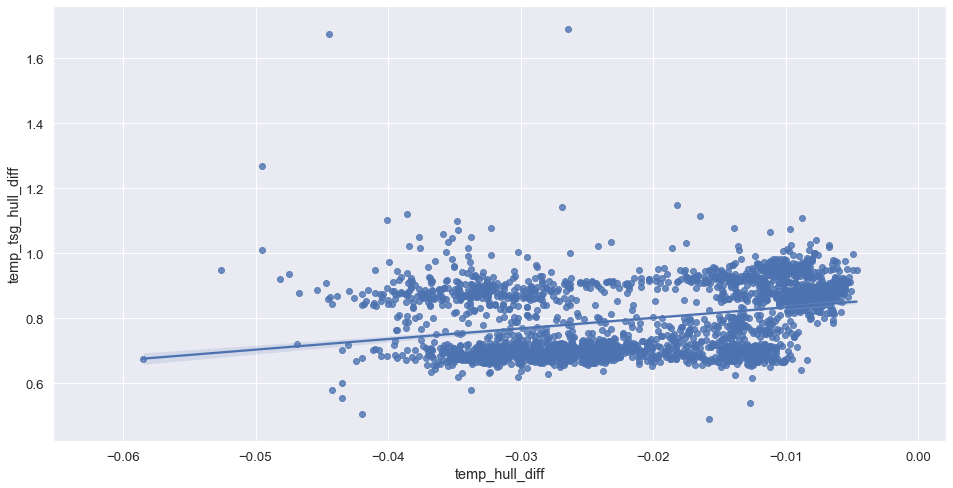

In [10]:
fig, ax = plt.subplots(figsize=(16,8))
x, y = np.array(ds.temp_hull_diff), np.array(ds.temp_tsg_hull_diff)

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

sns.regplot(x=ds.temp_hull_diff, y=ds.temp_tsg_hull_diff)

In [11]:
#HERE ARE STEPS MISSING WHERE I MIGHT LOOK A BIT FURTHER INTO THE ENGINE ROOM BIAS

In [12]:
#I am going to work with temperature (and we have decided to use the TSG temperature) and salinity (calibrated). I am going to drop of the variables I do not need. I also rename salinity and temperature.
#POT_TEMP --> LOOK AT WORKING NOTES
ds = ds.drop(['attenuation','conductivity_tsg','chl-a','sal_tsg_nocal','temp_hull_1','temp_hull_2']).rename({'sal_tsg_cal':'SP', 'temp_cond_tsg':'T'})

In [13]:
#I am going to check the influence of pressure on the data:
#Let's obtain the pressure, absolute salinity and conservative temperature. (As the water is pumped on-board the pressure is released)
ds['pressure'] = gsw.p_from_z(-ds.depth, ds.lat)
ds['SA'] = gsw.SA_from_SP(ds.SP, 0, ds.lon, ds.lat)
ds['CT'] = gsw.CT_from_t(ds.SA, ds.T, 0)

#Attributes for the variable
ds['pressure'].attrs = {
    'long_name': 'Pressure',
    'standard_name': 'press',
    'units': 'dbar',
    'description': 'Sea pressure from height using gsw.'}

ds['SA'].attrs = {
    'long_name': 'Absolute Salinity',
    'standard_name': 'CT',
    'units': 'g/kg',
    'description': 'Absolute salinity from practical salinity using gsw.'}

ds['CT'].attrs = {
    'long_name': 'Conservative Temperture',
    'standard_name': 'CT',
    'units': '°C',
    'description': 'Conservative temperature from potential temperature using gsw.'}

In [14]:
#Going to check something out. The operating pressure is 34.5 dbar max, let's say 30dbar. That means an approximate depth of 30m. Let's calculate the CT with this depth. 

In [15]:
CT_30 = gsw.CT_from_t(ds.SA, ds.T, 30)

[Text(0, 0.5, 'Temperature difference (°C)'),
 Text(0.5, 0, 'Distance travelled (km)')]

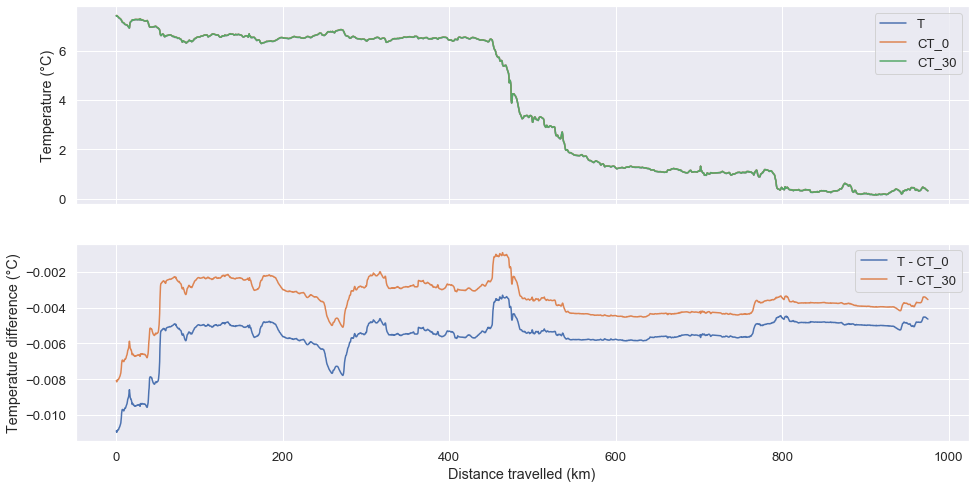

In [16]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16,8), sharex=True)

sns.lineplot(x=ds.distance_cum/1000, y=ds.T, label='T', ax=ax0)
sns.lineplot(x=ds.distance_cum/1000, y=ds.CT, label='CT_0', ax=ax0)
sns.lineplot(x=ds.distance_cum/1000, y=CT_30, label='CT_30', ax=ax0)

sns.lineplot(x=ds.distance_cum/1000, y=ds.T-ds.CT, label='T - CT_0', ax=ax1)
sns.lineplot(x=ds.distance_cum/1000, y=ds.T-CT_30, label='T - CT_30', ax=ax1)

ax0.legend()
ax0.set(xlabel='Distance travelled (km)', ylabel='Temperature (°C)')
ax1.set(xlabel='Distance travelled (km)', ylabel='Temperature difference (°C)')

In [17]:
#From here we can calculate the density. As the water is pumped to the surface it is moved adiabatically, so it actually is the the potential temperature
#Because the differences in conservative temperature of the pressure build of inside of the system is low, for now I will consider a zero depth.
ds['rho_pot'] = gsw.rho(ds.SA, ds.CT, 0)

ds['rho_pot'].attrs = {
    'long_name': 'Potential density',
    'standard_name': 'rho_pot',
    'units': 'kg m-3',
    'description': 'Potential density calculated from SA and CT at 0 pressure using gsw.'}

In [18]:
ds

<xarray.Dataset>
Dimensions:             (time: 2545)
Coordinates:
    lat                 (time) float64 -52.5 -52.5 -52.51 ... -61.19 -61.2
    lon                 (time) float64 -58.17 -58.17 -58.17 ... -57.09 -57.09
    depth               (time) float32 6.5 6.5 6.5 6.5 6.5 ... 6.5 6.5 6.5 6.5
  * time                (time) datetime64[ns] 2017-11-09T02:12:59.999680 ... 2017-11-10T23:37:59.997824
    distance_cum        (time) float64 0.0 264.2 567.0 ... 9.746e+05 9.75e+05
Data variables:
    SP                  (time) float32 33.695 33.69425 ... 33.934 33.9305
    T                   (time) float32 7.4051 7.40175 7.41585 ... 0.3236 0.3199
    temp_hull_diff      (time) float32 -0.01760006 -0.023849964 ... -0.00819999
    temp_tsg_hull_diff  (time) float32 0.6873498 0.69137526 ... 0.8899001
    pressure            (time) float64 6.558 6.558 6.558 ... 6.563 6.563 6.563
    SA                  (time) float64 33.85 33.85 33.85 ... 34.1 34.1 34.09
    CT                  (time) float64 7.416 7.413 7.427 ... 0.337 0.3282 0.3245
    rho_pot             (time) float64 1.026e+03 1.026e+03 ... 1.027e+03
Attributes:
    date_update:  2020-07-31T01:05:54+0100
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  trajectory
    title:        SeaDataNet NETCDF TRAJECTORY Climate Forecast 1.6 - GENERAT...

In [19]:
#This dataset has been reshaped, selected, QC and SA, CT and density has been calculated. It now can be saved as the preprocessing step.
#The next processing step is going to be gridding the data.
path_to = '.\\data\\02_intermediate\\tsg_orchestra\\b1903933_preprocessed.nc'
ds.to_netcdf(path_to)